# Variational Autoencoders

A *Neural Network* **and** a *Bayesian* approach

<img src="img/fashion-mnist-sprite.png"/>

# Dataset and utilities

Below we'll import some libraries and use some utility classes from `pytorch` and `torchvision`.

<img src="img/auto-encoder.png" width="900px"> </img>
<small>[1]</small>

In [1]:
import torchvision
from torchvision import transforms
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Load data
data_dir = './data'
t = transforms.ToTensor()

fashion = False
if fashion:
    dset = torchvision.datasets.FashionMNIST
else:
    dset = torchvision.datasets.MNIST

ds_train = dset(
    root=data_dir,
    train=True,
    transform=t,
    download=True
)

ds_test = dset(
    root=data_dir,
    transform=t,
    train=False
)

In [7]:
# Show types in dataset
[type(a) for a in next(iter(ds_train))]

[torch.Tensor, int]

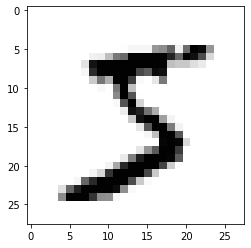

In [8]:
plt.imshow(next(iter(ds_train))[0].reshape(28, 28), cmap="Greys")

In [9]:
batch_size = 64

# Create dataloaders utilities
dl_train = DataLoader(ds_train, shuffle=True, batch_size=batch_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

# img and label
{k: (v.dtype, v.shape) for (k, v) in zip(['img', 'label'], next(iter(dl_train)))}

{'img': (torch.float32, torch.Size([64, 1, 28, 28])),
 'label': (torch.int64, torch.Size([64]))}

In [10]:
def loss_batch(model, criterion, x, opt=None):
    reconstruction_x = model(x)
    loss = criterion(reconstruction_x, x.view(-1, 784))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

def fit(epochs, model, criterion, optim, dl_train, dl_test, device='cuda', log_between_epochs=True):
    """
    :param epoch: int
    :param model: torch.nn.Module
    :param criterion: torch.optim.Optimizer
    :param dl_train: torch.utils.data.DataLoader
    :param dl_test: torch.utils.data.DataLoader
    :param device: str
        'cuda' or 'cpu'
    """
    for epoch in range(epochs):
        
        # train
        model.train()
        for i, (x, y) in enumerate(dl_train):
            loss, n = loss_batch(model, criterion, x.to(device), optim)
            
            if i % 150 == 0 and log_between_epochs:
                print("Loss: {:6.5f},\t iteration: {:4d}".format(loss / n, i))
        
        # evaluate test set
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, criterion, x.to(device)) for x, y in dl_test]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print("\nEpoch: {:4d},\t Test loss: {:6.5f}".format(epoch, val_loss))

In [ ]:

class AutoEncoder(nn.Module):
    def __init__(self, input_size=784, z_size=20):
        super().__init__()
        # Implement autoencoder
    
    def forward(self, x):
        x = x.view(-1, 784)
        z = self.encoder(x)
        x = self.decoder(z)
        
        if self.training:
            return x
        else:
            return F.sigmoid(x)

In [11]:

class AutoEncoder(nn.Module):
    def __init__(self, input_size=784, z_size=20):
        super().__init__()
        hidden_size = int((input_size - z_size) / 2 + z_size)
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, z_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )
    
    def forward(self, x):
        x = x.view(-1, 784)
        z = self.encoder(x)
        x = self.decoder(z)
        
        if self.training:
            return x
        else:
            return F.sigmoid(x)

In [12]:
model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
epochs = 1
device = 'cpu'

if torch.cuda.is_available():
    print('On cuda!')
    model.cuda()
    device = 'cuda'

On cuda!


In [13]:
fit(epochs, model, criterion, optim, dl_train, dl_test, device)

Loss: 0.01081,	 iteration:    0
Loss: 0.00195,	 iteration:  150
Loss: 0.00163,	 iteration:  300
Loss: 0.00167,	 iteration:  450
Loss: 0.00165,	 iteration:  600
Loss: 0.00162,	 iteration:  750
Loss: 0.00165,	 iteration:  900


/opt/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch:    0,	 Test loss: 0.67246


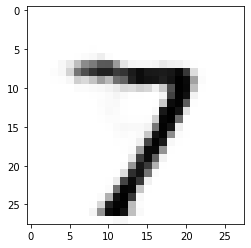

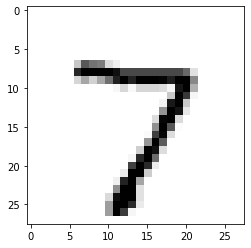

In [14]:
with torch.no_grad():
    model.eval()
    for x, _ in ds_test:
        x_reconstruction = model(x.to(device)).cpu()
        break

plt.imshow(x_reconstruction.view(28, 28), cmap='Greys')
plt.show()
plt.imshow(x.view(28, 28), cmap='Greys')

# Variational Autoencoder

## *A neural networks perspective*

Let $Q(z|x)$ be the encoder, and $P(x|z)$ the decoder. Both are neural networks.

We want to be able to generate new data, so we modify the autoencoder so that it has a random process at it's core.


$$ \begin{eqnarray}
Q_{\theta}(\cdot) &=& \{ \mu_{\theta}, \log \sigma^2_{\theta} \}\\
z &\sim& \mathcal{N}(\mu_{\theta}, \sigma^2_{\theta})
\end{eqnarray}$$

Now it's of course very easy for $E(\cdot)$ to cheat and become an autoencoder by just learning $E_{\theta}(\cdot) = \{ \mu_{\theta}, 0 \}$. Without variance the random process isn't quite random.

Therefore, we need a regularization term, the Kullback-Leibler-Divergence. 

$$ D_{KL}(Q(z|x) || P(z)) $$

Where we don't want the $z$ values we draw from the stochastic decoder to deviate too much from a unit Gaussian.

$$ \begin{eqnarray}
z &\sim& P(z) \\ 
  &\sim& \mathcal{N}(0, \text{diag}(\sigma^2)) 
\end{eqnarray}$$

## Generative model
## *A Bayesian perspective*

<img src="./img/plate-vae.png"/>

For each image $x_i$:

$$\begin{eqnarray}
z_i &\sim& \mathcal{N}(\mu_i, \sigma_i^2) \\
x_i &\sim& P(x_i|z_i)
\end{eqnarray}$$


## Bayesian inference

$$P(z|x) = \frac{P(x|z)P(z)}{P(x)} $$

## Can we solve this with MCMC?


## Approximate distribution

Let's define an approximate distribution $Q(Z) \approx P(z|x)$. We optimize the variables of $Q(z)$ so that it will be 'closer' to the true posterior $P(z|x)$

<img src="./img/easydist.png"/>

<img src="./img/dafuq.jpg"/>

## KL-divergence
There is a reason we choose to measure the 'closeseness' with the KL-divergence and not a real distance metric, such as the Wasserstein distance.

$$\begin{eqnarray}
D_{\text{KL}}(Q(z) \: || \: P(z|x)) &=& \int_{z} Q(z) \log \frac{Q(z)}{P(z|x)}\text{dz} \\
&=& \int_{z} q(z) \log \frac{q(z)p(x)}{p(z, x)}\text{d}z  &\qquad \tiny{\text{rewrite the posterior as}\frac{p(z, x)}{p(x)} } \\
&=& \int_{z} Q(z) \log \frac{Q(z)}{P(z, x)}\text{d}z + \int_{z} Q(z) \log P(x) \text{d} z \\
&=&  \int_{z} Q(z) \log \frac{Q(z)}{P(z, x)}\text{d}z +  \log P(x) &\qquad \tiny{P(x)\text{ is not parameterized by }z \text{and} \int_{z} Q(z) \text{d} z = 1} \\
&=& \log P(x) -\int_{z} Q(z) \log \frac{P(z, x)}{Q(z)}\text{d}z &\qquad \tiny{\log A = - \log \frac{q}{A}} \\
&=& \log P(x) - \underbrace{ E_{z \sim Q}[\log \frac{P(z, x)}{Q(z)} }_{\text{ELBO}} ]
\end{eqnarray}
$$

## Reconstruction loss and KL-divergence
In the derivation of Variational Autoencoders, the ELBO is often written in two terms; a reconstruction error and a KL-term on the variational distribution $Q_z$ and the prior $P(z)$

First we rewrite the joint probability $P(z, x)$ into conditional probability $P(x|z)P(z)$.

$$ \text{ELBO}  = E_{z \sim Q}[\log \frac{P(x|z)P(z)}{Q(z)} ] $$

Then we expand the equation and thereby isolating the reconstruction error $\log P(x|z)$, i.e. the log likelihood.

$$ \text{ELBO}  = E_{z \sim Q}[\log P(x|z)] +  E_{z \sim Q}[\log \frac{P(z)}{Q(z)}]$$

If we rewrite the $E_{z \sim Q}[\log \frac{P(z)}{Q(z)}]$ in the integral form $\int_{z} Q(z)\log\frac{P(z)}{Q(z)}dz$, we can observe that this is the KL-divergence between the prior $P(z)$ and the variational distribution $Q(z)$. Resulting in an ELBO defined by the reconstruction error and $-D_{KL}(Q(z)||P(z)).$

$$ \text{ELBO}  = E_{z \sim Q}[\log P(x|z)] - D_{KL}(Q(z)||P(z))$$


## Implementation

In [102]:
class VAE(nn.Module):
    def __init__(self, input_size=784, z_size=20):
        super().__init__()
        hidden_size = int((input_size - z_size) / 2 + z_size)
        self.z_size = z_size
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, z_size * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)  # unit gaussian
        z = mu + eps * std 
        return z
        
    def forward(self, x):
        x = x.view(-1, 784)
        variational_params = self.encoder(x)
        mu = variational_params[..., :self.z_size]
        log_var = variational_params[..., self.z_size:]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), z, mu, log_var


def loss_batch(model, criterion, x, opt=None):
    reconstruction_x, z, mu, log_var = model(x)
    loss = criterion(reconstruction_x, x.view(-1, 784))
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    loss += kl

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)



In [116]:
model = VAE()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss(reduction='sum')
epochs = 25
device = 'cpu'
batch_size = 256

dl_train = DataLoader(ds_train, shuffle=True, batch_size=batch_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

if torch.cuda.is_available():
    print('On cuda!')
    model.cuda()
    device = 'cuda'
    
    

On cuda!


In [117]:
fit(epochs, model, criterion, optim, dl_train, dl_test, device, log_between_epochs=False)


Epoch:    0,	 Test loss: 45651.31713

Epoch:    1,	 Test loss: 44757.27022

Epoch:    2,	 Test loss: 43418.09588

Epoch:    3,	 Test loss: 43290.16544

Epoch:    4,	 Test loss: 43172.56996

Epoch:    5,	 Test loss: 43022.13056

Epoch:    6,	 Test loss: 43347.33919

Epoch:    7,	 Test loss: 42884.59440

Epoch:    8,	 Test loss: 42916.98715

Epoch:    9,	 Test loss: 42681.94180

Epoch:   10,	 Test loss: 42751.86753

Epoch:   11,	 Test loss: 42673.31136

Epoch:   12,	 Test loss: 42635.39283

Epoch:   13,	 Test loss: 42672.09193

Epoch:   14,	 Test loss: 42560.42911

Epoch:   15,	 Test loss: 42571.33200

Epoch:   16,	 Test loss: 42495.00136

Epoch:   17,	 Test loss: 42640.09606

Epoch:   18,	 Test loss: 42661.70678

Epoch:   19,	 Test loss: 42861.99558

Epoch:   20,	 Test loss: 42472.55930

Epoch:   21,	 Test loss: 42630.67527

Epoch:   22,	 Test loss: 42511.97979

Epoch:   23,	 Test loss: 42701.39958

Epoch:   24,	 Test loss: 42459.78887


# Generate new samples

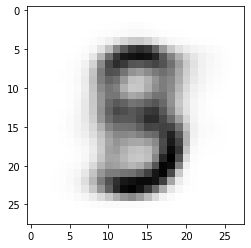

In [171]:
with torch.no_grad():
    z = torch.randn(20)
    x = model.decoder(z)
    plt.imshow(x.view(28, 28), Cmap='Greys')

# References
[1] https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html <br>
[2] https://jaan.io/what-is-variational-autoencoder-vae-tutorial/ <br>
[3] https://www.ritchievink.com/blog/2019/06/10/bayesian-inference-how-we-are-able-to-chase-the-posterior/ <br>
[4] https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/ <br>